In [2]:
import os
import sys
import logging
import argparse
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import spearmanr, pearsonr
from scipy.stats import gaussian_kde
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import  metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error,mean_squared_error
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
#Get the data and features
stat = pd.read_csv('Machine_learning/Data&Features_wo_0508.csv',index_col='Combination')
stat_col = stat.columns.to_list()
OHE_item = []
item = ['response']
for i in range(26):
    stat_col.append('OHE_'+str(i+1))
    OHE_item.append('OHE_'+str(i+1))
    item.append('OHE_'+str(i+1))
threshold = 250
libs = [0, 1, 2, 3, 5, 8]
target = 'miu'
#test size is 1/3
stat_train, stat_test = train_test_split(stat, test_size=1/3, random_state = 12)
datas_train, datas_test, datas = {},{},{}
arrays_train,arrays_test,arrays= {},{},{}
dfs_train,dfs_test,dfs = {},{},{}
X_ts,y_ts = {},{}
for lib in libs:
    datas_train['Lib_'+str(lib)] = stat_train[(stat_train['reads_sum_'+str(lib)+'A']>threshold) & \
                                 (stat_train['reads_sum_'+str(lib)+'B']>threshold) ].copy()
    arrays_train['Lib_'+str(lib)] = datas_train['Lib_'+str(lib)][['miu_Lib_'+str(lib),'con'+str(lib),'Linlog']+OHE_item].values
    dfs_train['Lib_'+str(lib)] = pd.DataFrame(columns = ['miu','con','Linlog']+OHE_item, \
                                              index = range(len(arrays_train['Lib_'+str(lib)])))
    dfs_train['Lib_'+str(lib)][['miu','con','Linlog']+OHE_item] = arrays_train['Lib_'+str(lib)]
    
    datas_test['Lib_'+str(lib)] = stat_test[(stat_test['reads_sum_'+str(lib)+'A']>threshold) & \
                                 (stat_test['reads_sum_'+str(lib)+'B']>threshold) ].copy()
    arrays_test['Lib_'+str(lib)] = datas_test['Lib_'+str(lib)][['miu_Lib_'+str(lib),'con'+str(lib),'Linlog']+OHE_item].values
    dfs_test['Lib_'+str(lib)] = pd.DataFrame(columns = ['miu','con','Linlog']+OHE_item, \
                                              index = range(len(arrays_test['Lib_'+str(lib)])))
    dfs_test['Lib_'+str(lib)][['miu','con','Linlog']+OHE_item] = arrays_test['Lib_'+str(lib)]
    X_ts['Lib_'+str(lib)] = dfs_test['Lib_'+str(lib)][['con','Linlog']+OHE_item].values
    y_ts['Lib_'+str(lib)] = dfs_test['Lib_'+str(lib)][target].values
    
    datas['Lib_'+str(lib)] = stat[(stat['reads_sum_'+str(lib)+'A']>threshold) & \
                                 (stat['reads_sum_'+str(lib)+'B']>threshold) ].copy()
    arrays['Lib_'+str(lib)] = datas['Lib_'+str(lib)][['miu_Lib_'+str(lib),'con'+str(lib),'Linlog']+OHE_item].values
    dfs['Lib_'+str(lib)] = pd.DataFrame(columns = ['miu','con','Linlog']+OHE_item, index = range(len(arrays['Lib_'+str(lib)])))
    dfs['Lib_'+str(lib)][['miu','con','Linlog']+OHE_item] = arrays['Lib_'+str(lib)]
    
data_df = pd.concat( [dfs['Lib_0'], dfs['Lib_1'], dfs['Lib_2'], dfs['Lib_3'], dfs['Lib_5'], dfs['Lib_8']], axis=0 )
train_df = pd.concat( [dfs_train['Lib_0'], dfs_train['Lib_1'], dfs_train['Lib_2'], \
                       dfs_train['Lib_3'], dfs_train['Lib_5'], dfs_train['Lib_8']], axis=0 )
test_df = pd.concat( [dfs_test['Lib_0'], dfs_test['Lib_1'], dfs_test['Lib_2'], \
                      dfs_test['Lib_3'], dfs_test['Lib_5'], dfs_test['Lib_8']], axis=0 )
X_train = train_df[['con','Linlog']+OHE_item].values
X_test = test_df[['con','Linlog']+OHE_item].values
y_train = train_df[target].values
y_test = test_df[target].values
X_total = data_df[['con','Linlog']+OHE_item].values
y_total = data_df[target].values

In [61]:
X_total.shape

(14377, 28)

In [62]:
X_train.shape

(9611, 28)

In [63]:
X_test.shape

(4766, 28)

In [64]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    #errors = abs(predictions - test_labels)
    #mape = 100 * np.mean(errors / abs(test_labels))
    #accuracy = 100 - mape
    corr = spearmanr(predictions, test_labels)
    pcc = pearsonr(predictions, test_labels)
    mse = mean_squared_error(test_labels, predictions)
    mae = mean_absolute_error(test_labels, predictions)
    per = [pcc[0],mse,mae]
    print('Model Performance')
    print('Spearmanr for test set',corr)
    print('Pearson for test set',pcc[0])
    print("MSE: %.6f" % mse)
    print("MAE: %.6f" % mae)
    
    return per

In [65]:
#Linear Regression
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train,y_train)
linreg_eval = evaluate(linreg,X_test,y_test)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9391906707175168, pvalue=0.0)
Pearson for test set 0.9579959147723548
MSE: 0.034282
MAE: 0.144247


In [66]:
from sklearn.linear_model import RidgeCV,LassoCV
from sklearn.model_selection import GridSearchCV
#Regularization
alpha = np.logspace(-4,2,100)
#Ridge regression
ridge = RidgeCV(alpha,cv=10)
ridge.fit(X_train,y_train)
ridge.alpha_

7.054802310718645

In [67]:
ridge_eval = evaluate(ridge,X_test,y_test)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9392046285285741, pvalue=0.0)
Pearson for test set 0.9579962118789026
MSE: 0.034282
MAE: 0.144249


In [68]:
#Lasso regression
lasso = LassoCV(alphas=alpha,cv=10)
lasso.fit(X_train,y_train)
lasso.alpha_

0.0001

In [69]:
lasso_eval = evaluate(lasso,X_test,y_test)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9392015897923408, pvalue=0.0)
Pearson for test set 0.9580134494199228
MSE: 0.034268
MAE: 0.144154


In [70]:
linreg_eval_train = evaluate(linreg,X_train,y_train)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9370523856463643, pvalue=0.0)
Pearson for test set 0.9557150642619756
MSE: 0.033750
MAE: 0.141009


In [71]:
ridge_eval_train = evaluate(ridge,X_train,y_train)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9370668361600815, pvalue=0.0)
Pearson for test set 0.9557146077934104
MSE: 0.033753
MAE: 0.141073


In [72]:
lasso_eval_train = evaluate(lasso,X_train,y_train)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9370735599620057, pvalue=0.0)
Pearson for test set 0.9557137332258698
MSE: 0.033751
MAE: 0.140973


In [14]:
from sklearn.svm import SVR
param_SVR = {'kernel':['linear','poly', 'rbf','sigmoid'],'gamma':['auto','scale']}
gsearch_svr = GridSearchCV(estimator = SVR(), param_grid = param_SVR,scoring= 'neg_mean_squared_error',\
                           n_jobs=4,iid=False, cv = 10)
gsearch_svr.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid=False, n_jobs=4,
             param_grid={'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [15]:
cv_svr_df1 = pd.DataFrame.from_dict(gsearch_svr.cv_results_)

In [16]:
cv_svr_df1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,10.478738,0.211920,0.116426,0.003734,auto,linear,"{'gamma': 'auto', 'kernel': 'linear'}",-0.033402,-0.032853,-0.028470,-0.030240,-0.033391,-0.034263,-0.034291,-0.039874,-0.040387,-0.045807,-0.035298,0.004947,4
1,2.405258,0.054664,0.111261,0.003547,auto,poly,"{'gamma': 'auto', 'kernel': 'poly'}",-0.130835,-0.102932,-0.063098,-0.047543,-0.033074,-0.015914,-0.011144,-0.014379,-0.010547,-0.013819,-0.044328,0.040354,6
2,1.356503,0.048608,0.073769,0.002175,auto,rbf,"{'gamma': 'auto', 'kernel': 'rbf'}",-0.009974,-0.007926,-0.008313,-0.008205,-0.008545,-0.009761,-0.006805,-0.008852,-0.010504,-0.013591,-0.009248,0.001776,2
3,4.769790,0.859683,0.349858,0.021885,auto,sigmoid,"{'gamma': 'auto', 'kernel': 'sigmoid'}",-35017.455907,-24751.660425,-233.457132,-10206.323481,-14890.455274,-21398.920245,-15072.346887,-62.971732,-97771.278769,-122556.539344,-34196.140920,39667.968508,7
4,10.131770,0.130512,0.118029,0.005451,scale,linear,"{'gamma': 'scale', 'kernel': 'linear'}",-0.033402,-0.032853,-0.028470,-0.030240,-0.033391,-0.034263,-0.034291,-0.039874,-0.040387,-0.045807,-0.035298,0.004947,4
5,2.892572,0.286817,0.087206,0.012819,scale,poly,"{'gamma': 'scale', 'kernel': 'poly'}",-0.072121,-0.052161,-0.029724,-0.021254,-0.015811,-0.010462,-0.007783,-0.011526,-0.008296,-0.010290,-0.023943,0.020621,3
6,1.325470,0.104844,0.066487,0.004687,scale,rbf,"{'gamma': 'scale', 'kernel': 'rbf'}",-0.009448,-0.007200,-0.007717,-0.007500,-0.007627,-0.008950,-0.006173,-0.007979,-0.009073,-0.012102,-0.008377,0.001549,1
7,4.467310,0.227522,0.358281,0.025633,scale,sigmoid,"{'gamma': 'scale', 'kernel': 'sigmoid'}",-89187.784292,-64900.605247,-5925.468388,-28164.752735,-40732.866202,-51851.983733,-37877.788765,-45104.368487,-625667.545197,-836671.547964,-182608.471101,279075.699148,8


In [17]:
# rbf kernel
rbf_svr = SVR(kernel = "rbf", gamma = 'scale')
rbf_svr.fit(X_train, y_train)
rbf_svr_eval = evaluate(rbf_svr , X_test, y_test)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9815987541938951, pvalue=0.0)
Pearson for test set 0.9908940026149563
MSE: 0.007643
MAE: 0.066448


In [18]:
rbf_svr_eval_train = evaluate(rbf_svr , X_train, y_train)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9853218305079285, pvalue=0.0)
Pearson for test set (0.9909932703736293, 0.0)
MSE: 0.007093
MAE: 0.061153


In [19]:
# Create the parameter grid based on the results of random search 
param_grid_rfr = {'min_samples_leaf': [1, 2, 3],'min_samples_split': [2, 3],\
                  'n_estimators': [100,500,800]}
# Create a based model
rfr = RandomForestRegressor(random_state = 42)
# Instantiate the grid search model
gsearch_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid_rfr,scoring= 'neg_mean_squared_error',\
                           n_jobs = 4, iid = False, cv = 10)
gsearch_rfr.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid=False, n_jobs=4,
             param_grid={'min_samples_leaf': [1, 2, 3],
     

In [20]:
cv_rfr_df1 = pd.DataFrame.from_dict(gsearch_rfr.cv_results_)

In [21]:
cv_rfr_df1.iloc[2]

mean_fit_time                                                        17.2267
std_fit_time                                                         1.16954
mean_score_time                                                     0.179538
std_score_time                                                     0.0185352
param_min_samples_leaf                                                     1
param_min_samples_split                                                    2
param_n_estimators                                                       800
params                     {'min_samples_leaf': 1, 'min_samples_split': 2...
split0_test_score                                                -0.00378458
split1_test_score                                                -0.00374554
split2_test_score                                                -0.00342725
split3_test_score                                                -0.00250118
split4_test_score                                                -0.00221079

In [73]:
rfr_model = RandomForestRegressor(n_estimators = 800, min_samples_leaf=1, min_samples_split=2)
rfr_model.fit(X_train, y_train)
rfr_per= evaluate(rfr_model, X_test, y_test)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9840752536900065, pvalue=0.0)
Pearson for test set 0.9885404988911679
MSE: 0.009501
MAE: 0.062314


In [23]:
# Create the parameter grid based on the results of random search 
param_grid_rfr2 = {'n_estimators': range(750,1000,10)}
# Create a based model
rfr = RandomForestRegressor(min_samples_leaf=1, min_samples_split=2)
# Instantiate the grid search model
gsearch_rfr2 = GridSearchCV(estimator = rfr, param_grid = param_grid_rfr2,scoring= 'neg_mean_squared_error',\
                           n_jobs = 4, iid = False, cv = 10)
gsearch_rfr2.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(750, 1000, 1

In [24]:
cv_rfr_df2 = pd.DataFrame.from_dict(gsearch_rfr2.cv_results_)

In [25]:
cv_rfr_df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,15.777465,0.271155,0.225804,0.038058,750,{'n_estimators': 750},-0.003825,-0.003743,-0.003412,-0.002538,-0.002222,-0.002312,-0.001967,-0.002268,-0.002464,-0.002394,-0.002714,0.000643,3
1,16.063389,0.446332,0.180974,0.035150,760,{'n_estimators': 760},-0.003805,-0.003760,-0.003434,-0.002542,-0.002269,-0.002373,-0.002031,-0.002261,-0.002476,-0.002435,-0.002739,0.000628,23
2,14.945272,0.062839,0.156393,0.014688,770,{'n_estimators': 770},-0.003812,-0.003745,-0.003414,-0.002567,-0.002208,-0.002362,-0.002012,-0.002260,-0.002445,-0.002413,-0.002724,0.000634,10
3,15.135274,0.099886,0.165543,0.018915,780,{'n_estimators': 780},-0.003792,-0.003763,-0.003391,-0.002552,-0.002260,-0.002368,-0.002013,-0.002222,-0.002432,-0.002365,-0.002716,0.000633,4
4,15.457159,0.142270,0.159527,0.015637,790,{'n_estimators': 790},-0.003807,-0.003713,-0.003403,-0.002530,-0.002188,-0.002370,-0.001992,-0.002224,-0.002499,-0.002419,-0.002714,0.000632,1
5,15.509075,0.069322,0.157674,0.014231,800,{'n_estimators': 800},-0.003824,-0.003771,-0.003435,-0.002559,-0.002262,-0.002378,-0.001985,-0.002247,-0.002458,-0.002380,-0.002730,0.000643,19
6,15.728933,0.077365,0.160359,0.016287,810,{'n_estimators': 810},-0.003850,-0.003776,-0.003436,-0.002589,-0.002212,-0.002348,-0.002008,-0.002289,-0.002487,-0.002406,-0.002740,0.000645,25
7,15.927379,0.109664,0.160558,0.013191,820,{'n_estimators': 820},-0.003852,-0.003701,-0.003414,-0.002564,-0.002243,-0.002365,-0.002003,-0.002283,-0.002444,-0.002383,-0.002725,0.000632,11
8,16.132850,0.117002,0.162372,0.013884,830,{'n_estimators': 830},-0.003822,-0.003738,-0.003511,-0.002591,-0.002236,-0.002329,-0.002003,-0.002292,-0.002473,-0.002403,-0.002740,0.000643,24
9,16.257676,0.061956,0.174779,0.019051,840,{'n_estimators': 840},-0.003816,-0.003768,-0.003387,-0.002519,-0.002275,-0.002358,-0.002010,-0.002268,-0.002490,-0.002381,-0.002727,0.000632,16


In [74]:
rfr_model = RandomForestRegressor(n_estimators = 770, min_samples_leaf=1, min_samples_split=2)
rfr_model.fit(X_train, y_train)
rfr_per= evaluate(rfr_model, X_test, y_test)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9840698996172969, pvalue=0.0)
Pearson for test set 0.9885348471883255
MSE: 0.009506
MAE: 0.062291


In [27]:
param_grid_xgbr = {'n_estimators':range(100,600,10)}
gsearch_xgbr = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1,max_depth=9,gamma = 0,\
                                                 min_child_weight=1,subsample=0.8,colsample_bytree=0.8,\
                                                 nthread=4,scale_pos_weight=1,reg_alpha=0,\
                                                 objective='reg:squarederror',seed=42), \
                                    param_grid = param_grid_xgbr,scoring= 'neg_mean_squared_error',n_jobs=4,iid=False, cv=10)
gsearch_xgbr.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=9,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=42, silent=None,
                                    subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(100, 600, 10)},
             pre_dispatch='2*n_jobs', refit=True, return_

In [28]:
cv_xgbr_df1 = pd.DataFrame.from_dict(gsearch_xgbr.cv_results_)

In [29]:
cv_xgbr_df1[cv_xgbr_df1['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
34,14.557,0.229315,0.019769,0.001071,440,{'n_estimators': 440},-0.001661,-0.001373,-0.001005,-0.000782,-0.000869,-0.0009,-0.000887,-0.000985,-0.00102,-0.001189,-0.001067,0.000256,1


In [75]:
xgb4 = XGBRegressor(learning_rate =0.1,n_estimators=440,max_depth=9,min_child_weight=1,gamma=0,\
                    subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1,reg_alpha=0,\
                    objective='reg:squarederror',seed=42)
xgb4.fit(X_train,y_train)
xgb_per = evaluate(xgb4, X_test, y_test)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9871075793295591, pvalue=0.0)
Pearson for test set 0.992820746937037
MSE: 0.006026
MAE: 0.048552


In [76]:
xgb_per_train = evaluate(xgb4, X_train, y_train)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9997648255208634, pvalue=0.0)
Pearson for test set 0.9999345306235532
MSE: 0.000051
MAE: 0.005351


In [32]:
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
model_gbr = GradientBoostingRegressor(min_samples_leaf=1,min_samples_split=2,n_estimators=500)
model_gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
gbr_per = evaluate(model_gbr, X_test, y_test)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.983843343375145, pvalue=0.0)
Pearson for test set 0.9922089984225888
MSE: 0.006473
MAE: 0.058012


In [34]:
# Create the parameter grid based on the results of random search 
param_grid_gbr = {'min_samples_leaf': [1, 2, 3],'min_samples_split': [2, 3],\
                  'n_estimators': [100,200,300, 400,500]}
# Create a based model
model_gbr = GradientBoostingRegressor(random_state = 42)
# Instantiate the grid search model
gsearch_gbr = GridSearchCV(estimator = model_gbr, param_grid = param_grid_gbr,scoring= 'neg_mean_squared_error',\
                           n_jobs = 4, iid = False, cv = 10)
gsearch_gbr.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
               

In [35]:
cv_gbr_df1 = pd.DataFrame.from_dict(gsearch_gbr.cv_results_)

In [36]:
cv_gbr_df1.iloc[4]

mean_fit_time                                                          4.858
std_fit_time                                                        0.580884
mean_score_time                                                   0.00978992
std_score_time                                                    0.00138208
param_min_samples_leaf                                                     1
param_min_samples_split                                                    2
param_n_estimators                                                       500
params                     {'min_samples_leaf': 1, 'min_samples_split': 2...
split0_test_score                                                -0.00875621
split1_test_score                                                -0.00622739
split2_test_score                                                 -0.0069064
split3_test_score                                                -0.00541373
split4_test_score                                                -0.00576297

In [37]:
# Create the parameter grid based on the results of random search 
param_grid_gbr2 = {'n_estimators': range(400,800,10)}
# Create a based model
model_gbr = GradientBoostingRegressor(min_samples_leaf=1,min_samples_split=2,random_state = 42)
# Instantiate the grid search model
gsearch_gbr2 = GridSearchCV(estimator = model_gbr, param_grid = param_grid_gbr2,scoring= 'neg_mean_squared_error',\
                           n_jobs = 4, iid = False, cv = 10)
gsearch_gbr2.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
               

In [38]:
cv_gbr_df2 = pd.DataFrame.from_dict(gsearch_gbr2.cv_results_)
cv_gbr_df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,3.376415,0.240798,0.006751,0.001049,400,{'n_estimators': 400},-0.009194,-0.006560,-0.007244,-0.005803,-0.006243,-0.007523,-0.005538,-0.007594,-0.007236,-0.008170,-0.007110,0.001056,40
1,4.142042,0.471815,0.007767,0.001017,410,{'n_estimators': 410},-0.009102,-0.006519,-0.007222,-0.005754,-0.006213,-0.007480,-0.005461,-0.007514,-0.007164,-0.008147,-0.007058,0.001051,39
2,4.683237,0.225991,0.008655,0.000371,420,{'n_estimators': 420},-0.009065,-0.006471,-0.007212,-0.005720,-0.006172,-0.007442,-0.005399,-0.007442,-0.007082,-0.008077,-0.007008,0.001050,38
3,4.944295,0.263110,0.008330,0.000777,430,{'n_estimators': 430},-0.009033,-0.006406,-0.007173,-0.005665,-0.006117,-0.007413,-0.005326,-0.007332,-0.006982,-0.008007,-0.006946,0.001056,37
4,4.317839,0.092634,0.007532,0.000567,440,{'n_estimators': 440},-0.008965,-0.006383,-0.007130,-0.005626,-0.006053,-0.007368,-0.005293,-0.007278,-0.006922,-0.007888,-0.006891,0.001041,36
5,4.318550,0.195319,0.007919,0.000719,450,{'n_estimators': 450},-0.008887,-0.006381,-0.007088,-0.005555,-0.005974,-0.007329,-0.005233,-0.007217,-0.006872,-0.007792,-0.006833,0.001036,35
6,4.608865,0.153112,0.008808,0.001166,460,{'n_estimators': 460},-0.008861,-0.006326,-0.007068,-0.005527,-0.005929,-0.007290,-0.005166,-0.007160,-0.006825,-0.007730,-0.006788,0.001041,34
7,5.586573,0.564929,0.009654,0.001133,470,{'n_estimators': 470},-0.008839,-0.006302,-0.007021,-0.005503,-0.005887,-0.007234,-0.005116,-0.007128,-0.006768,-0.007657,-0.006746,0.001040,33
8,5.547273,0.058052,0.009645,0.001092,480,{'n_estimators': 480},-0.008805,-0.006260,-0.007002,-0.005475,-0.005856,-0.007200,-0.005074,-0.007073,-0.006717,-0.007586,-0.006705,0.001037,32
9,5.625720,0.455749,0.010263,0.001399,490,{'n_estimators': 490},-0.008775,-0.006219,-0.006973,-0.005445,-0.005815,-0.007168,-0.005018,-0.007040,-0.006663,-0.007547,-0.006666,0.001041,31


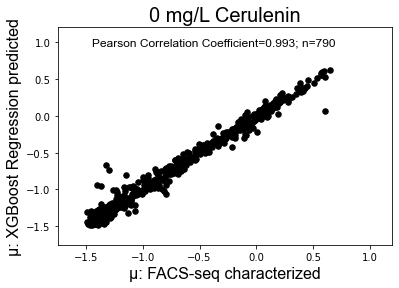

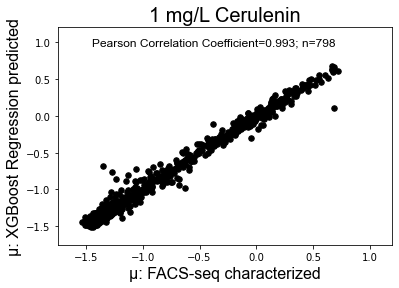

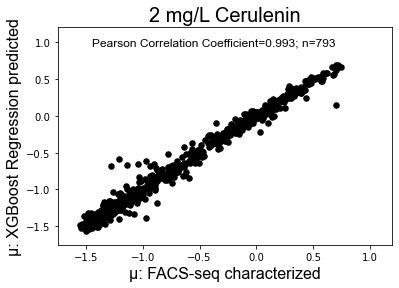

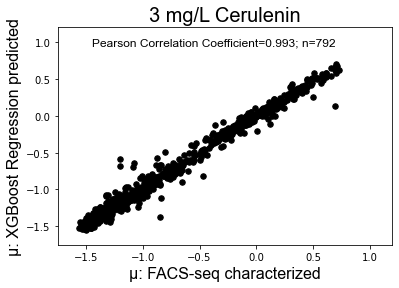

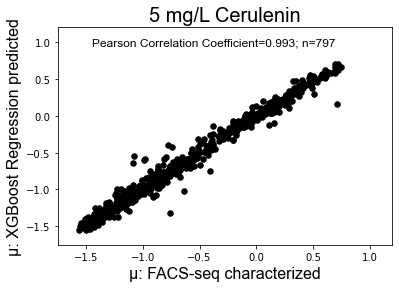

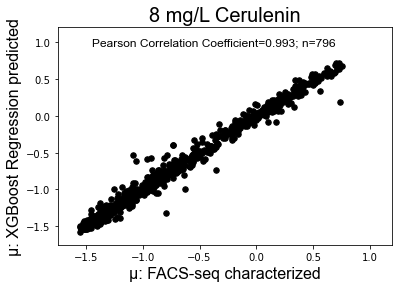

In [129]:
y_test_ps, compare_tests = {},{}
for lib in libs:
    y_test_ps['Lib_'+str(lib)] = xgb4.predict(X_ts['Lib_'+str(lib)])
    compare_tests['Lib_'+str(lib)] = pd.DataFrame(columns = ['y_test','y_predict'], index = \
                                                  range(len(y_test_ps['Lib_'+str(lib)])))
    compare_tests['Lib_'+str(lib)]['y_test'] = dfs_test['Lib_'+str(lib)]['miu'].values
    compare_tests['Lib_'+str(lib)]['y_predict'] = y_test_ps['Lib_'+str(lib)]
colors = {'Lib_0':'black','Lib_1':'black','Lib_2':'black',\
          'Lib_3':'black','Lib_5':'black','Lib_8':'black'}
for lib in libs:
    plt.scatter(compare_tests['Lib_'+str(lib)]['y_test'].values, \
                compare_tests['Lib_'+str(lib)]['y_predict'].values, s=30, color = colors['Lib_'+str(lib)])
    plt.text(-1.45,0.95,'Pearson Correlation Coefficient=%s; n=%d'%(("{0:.3f}".\
        format(compare_tests['Lib_'+str(lib)].corr()['y_test']['y_predict'])),\
        len(compare_tests['Lib_'+str(lib)].dropna())),fontsize=12,fontproperties = 'Arial')
    plt.xlabel('μ: FACS-seq characterized', fontsize = 16,fontproperties = 'Arial')
    plt.ylabel('μ: XGBoost Regression predicted', fontsize = 16,fontproperties = 'Arial')
    plt.title('%s mg/L Cerulenin'%(lib),fontsize = 20,fontproperties = 'Arial')
    plt.axis([-1.75, 1.2, -1.75, 1.2])
    plt.savefig('ExportResults/Compare_test_corr_XGBoost_Lib_%s_0511.png'%(lib),dpi = 1000)
    plt.show()

In [40]:
param_grid_xgbr = {'n_estimators':range(400,800,10)}
gsearch_xgbr = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1,max_depth=9,gamma = 0,\
                                                 min_child_weight=1,subsample=0.8,colsample_bytree=0.8,\
                                                 nthread=4,scale_pos_weight=1,reg_alpha=0,\
                                                 objective='reg:squarederror',seed=42), \
                                    param_grid = param_grid_xgbr,scoring= 'neg_mean_squared_error',n_jobs=4,iid=False, cv=10)
gsearch_xgbr.fit(X_total,y_total)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=0.8, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=9,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=4,
                                    objective='reg:squarederror',
                                    random_state=0, reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=42, silent=None,
                                    subsample=0.8, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'n_estimators': range(400, 800, 10)},
             pre_dispatch='2*n_jobs', refit=True, return_

In [41]:
cv_xgbr_total = pd.DataFrame.from_dict(gsearch_xgbr.cv_results_)

In [42]:
cv_xgbr_total[cv_xgbr_total['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,19.521246,0.339489,0.028877,0.001965,400,{'n_estimators': 400},-0.006448,-0.00562,-0.001434,-0.004572,-0.00318,-0.0022,-0.001736,-0.001273,-0.002323,-0.001303,-0.003009,0.001796,1


In [78]:
xgb_total = XGBRegressor(learning_rate =0.1,n_estimators=400,max_depth=9,min_child_weight=1,gamma=0,\
                    subsample=0.8,colsample_bytree=0.8,nthread=4,scale_pos_weight=1,reg_alpha=0.0,\
                    objective='reg:squarederror',seed=42)
xgb_total.fit(X_total,y_total)
xgb_total_accuracy = evaluate(xgb_total, X_total, y_total)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9995087024403352, pvalue=0.0)
Pearson for test set 0.9998738061314045
MSE: 0.000101
MAE: 0.007462


In [79]:
varimp = pd.DataFrame(xgb_total.feature_importances_, columns= ['Scaled importance'],index = range(28))
varimp['Feature'] = ['con','Linlog']+OHE_item

In [80]:
varimp

,Scaled importance,Feature
0,0.004181,con
1,0.055862,Linlog
2,0.001207,OHE_1
3,0.001748,OHE_2
4,0.001105,OHE_3
5,0.051156,OHE_4
6,0.602928,OHE_5
7,0.067822,OHE_6
8,0.044487,OHE_7
9,0.035677,OHE_8


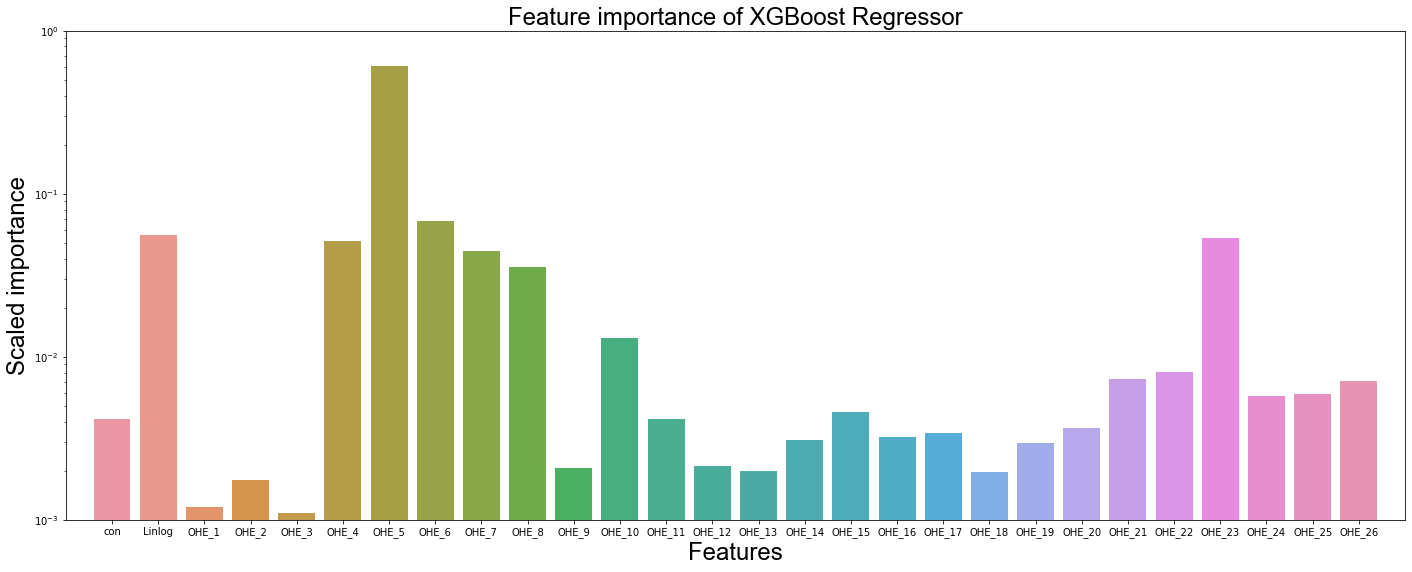

In [115]:
import seaborn as sns
import matplotlib
ax = plt.figure(figsize = (24,9))
sns.barplot(data=varimp,x='Feature',y="Scaled importance")
plt.semilogy()
plt.axis([-1,28,0.001,1])
plt.title("Feature importance of XGBoost Regressor",fontsize = 24,fontproperties = 'Arial')
plt.xlabel("Features", fontsize = 24,fontproperties = 'Arial')
plt.ylabel("Scaled importance", fontsize = 24,fontproperties = 'Arial')
plt.savefig('ExportResults/XGBoost_Feature_imp_0511.png',dpi = 1000)
plt.show()

In [82]:
X_libs,y_libs = {},{}
for lib in libs:
    X_libs['Lib_'+str(lib)] = stat[['con'+str(lib),'Linlog']+OHE_item].values
    y_libs['Lib_'+str(lib)] = xgb_total.predict(X_libs['Lib_'+str(lib)])
results = stat.copy()
for lib in libs:
    results['pre_Lib_'+str(lib)] = y_libs['Lib_'+str(lib)] 

In [83]:
from scipy.optimize import curve_fit
def hill_func(x,a,b,th,n):
    #n = 5
    return b+a*(x/th)**n/(1+(x/th)**n)
cerulenin = [0,1,2,3,5,8]
curve = results.copy()
curve['Dynamic Range'] = None
curve['Basal'] = None
curve['Threshold'] = None
curve['Factor'] = None
curve['Maximum increase'] = None
curve['Sensitivity'] = None
a_index = list(curve.columns).index('Maximum increase')
b_index = list(curve.columns).index('Basal')
th_index = list(curve.columns).index('Threshold')
n_index = list(curve.columns).index('Factor')
d_index = list(curve.columns).index('Dynamic Range')
s_index = list(curve.columns).index('Sensitivity')
for i in range(len(curve)):
    combi = curve.index[i]
    y = 100*10**curve[['pre_Lib_0','pre_Lib_1','pre_Lib_2','pre_Lib_3','pre_Lib_5','pre_Lib_8']].iloc[i].values
    a, b = curve_fit(hill_func, cerulenin, y,bounds=([0,0,0,0],[(y.max()-y.min()),y.min(),10,3]))
    curve.iloc[i, a_index] = a[0]
    curve.iloc[i, b_index] = a[1]
    curve.iloc[i, th_index] = a[2]
    curve.iloc[i, n_index] = a[3]
    curve.iloc[i, d_index] = a[0]/a[1]
    curve.iloc[i, s_index] = a[0]*a[3]/4/a[2]

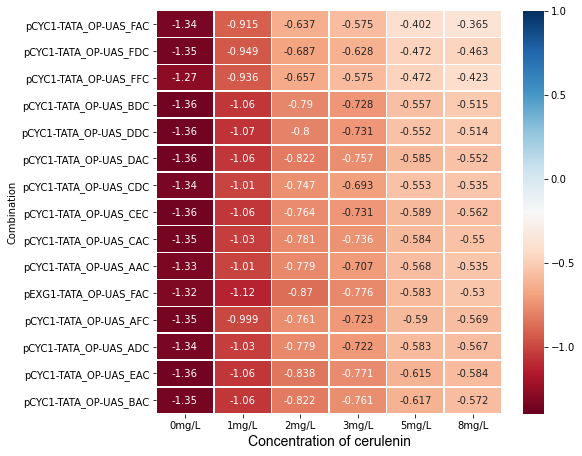

In [117]:
Dynamic_sort_ = curve.sort_values(by="Dynamic Range" , ascending=False).copy()
matri = Dynamic_sort_[['pre_Lib_0','pre_Lib_1','pre_Lib_2','pre_Lib_3','pre_Lib_5','pre_Lib_8']][0:15]
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,8)) 
ax = sns.heatmap(matri, vmin=-1.4, vmax= 1.0,cmap='RdBu',\
                 robust=False, annot = True, \
                 fmt='.3g', linewidths=0.5, \
                 linecolor='white', cbar=True, square=False, \
                 xticklabels=['0mg/L','1mg/L','2mg/L','3mg/L','5mg/L','8mg/L'], ax=ax)
plt.xlabel('Concentration of cerulenin',fontsize = 14,fontproperties = 'Arial')
plt.subplots_adjust(left = 0.4, bottom = 0.2, right = 0.9, top = 0.9)
plt.savefig('ExportResults/LargeDynamic0511.png',bbox_inches='tight',dpi=500,pad_inches=0.1) 
plt.show()

In [85]:
matri.to_excel('Machine_learning/matri_Top15.xlsx')

In [86]:
matri

,pre_Lib_0,pre_Lib_1,pre_Lib_2,pre_Lib_3,pre_Lib_5,pre_Lib_8
Combination,,,,,,
pCYC1-TATA_OP-UAS_FAC,-1.337582,-0.915445,-0.637124,-0.574893,-0.401847,-0.365227
pCYC1-TATA_OP-UAS_FDC,-1.348639,-0.948971,-0.687204,-0.627766,-0.472475,-0.463380
pCYC1-TATA_OP-UAS_FFC,-1.272486,-0.936183,-0.656664,-0.575165,-0.471955,-0.423208
pCYC1-TATA_OP-UAS_BDC,-1.358615,-1.057515,-0.789823,-0.727677,-0.557251,-0.514564
pCYC1-TATA_OP-UAS_DDC,-1.356310,-1.067482,-0.799578,-0.731367,-0.552102,-0.513734
pCYC1-TATA_OP-UAS_DAC,-1.357735,-1.056454,-0.822399,-0.756521,-0.584803,-0.551883
pCYC1-TATA_OP-UAS_CDC,-1.337950,-1.008326,-0.746609,-0.693108,-0.553275,-0.535453
pCYC1-TATA_OP-UAS_CEC,-1.359618,-1.057091,-0.763797,-0.731086,-0.588706,-0.561779
pCYC1-TATA_OP-UAS_CAC,-1.346216,-1.031673,-0.780510,-0.736329,-0.584486,-0.549970


In [87]:
linreg_eval = evaluate(linreg, X_test, y_test)

Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9391906707175168, pvalue=0.0)
Pearson for test set 0.9579959147723548
MSE: 0.034282
MAE: 0.144247


In [57]:
compare = {}
compare['TrainSet'] = {}
compare['TestSet'] = {}
models = [linreg,ridge,lasso,rbf_svr,rfr_model,model_gbr,xgb4]
names = ['Linear Regression','Ridge regression','Lasso regression',\
        'Support Vector Regression','Random Forest Regression','Gradient Boosting Regression','XGBoost Regression']
items = ['PCC','MSE','MAE']
for i in range(7):
    print(names[i])
    models[i].fit(X_train,y_train)
    train_eval = evaluate(models[i], X_train, y_train)
    test_eval = evaluate(models[i], X_test, y_test)
    compare['TrainSet'][names[i]] = {}
    compare['TestSet'][names[i]] ={}
    for j in range(3):
        compare['TrainSet'][names[i]][items[j]] = train_eval[j]
        compare['TestSet'][names[i]][items[j]] = test_eval[j]

Linear Regression
Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9370523856463643, pvalue=0.0)
Pearson for test set 0.9557150642619756
MSE: 0.033750
MAE: 0.141009
Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9391906707175168, pvalue=0.0)
Pearson for test set 0.9579959147723549
MSE: 0.034282
MAE: 0.144247
Ridge regression
Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9370668361600815, pvalue=0.0)
Pearson for test set 0.9557146077934107
MSE: 0.033753
MAE: 0.141073
Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9392046285285741, pvalue=0.0)
Pearson for test set 0.9579962118789026
MSE: 0.034282
MAE: 0.144249
Lasso regression
Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9370735599620057, pvalue=0.0)
Pearson for test set 0.9557137332258698
MSE: 0.033751
MAE: 0.140973
Model Performance
Spearmanr for test set SpearmanrResult(correlation=0.9392015897923408, pvalue=0.0)
Pe

In [58]:
compare_train_df = pd.DataFrame.from_dict(compare['TrainSet'])
compare_test_df = pd.DataFrame.from_dict(compare['TestSet'])

In [59]:
compare_test_df.to_excel('Machine_learning/TestSet_per.xlsx')
compare_train_df.to_excel('Machine_learning/TrainSet_per.xlsx')

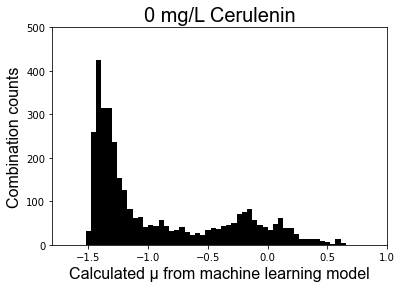

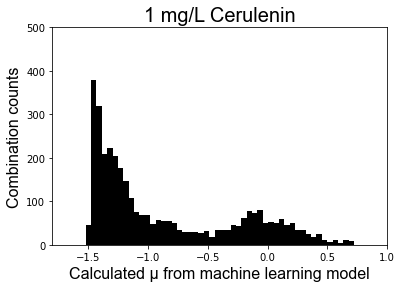

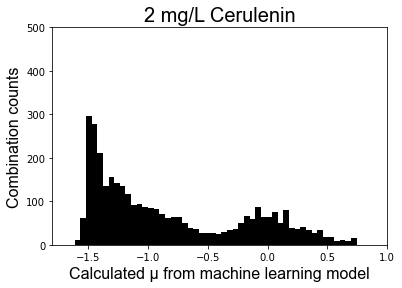

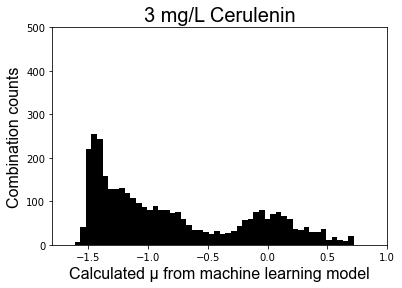

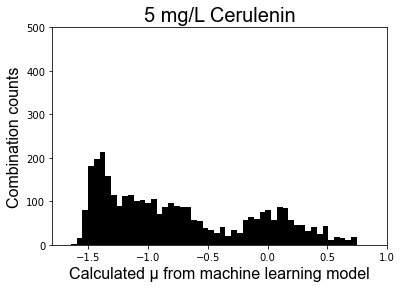

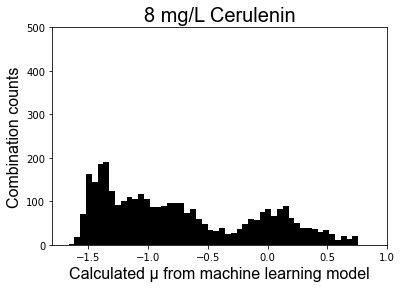

In [118]:
_bin_count = 50
plt.rcParams['figure.figsize'] = [6, 4]
for lib in libs:
    plt.hist(results['pre_Lib_'+str(lib)].values, bins = _bin_count,color= colors['Lib_'+str(lib)])
    plt.title(str(lib)+' mg/L Cerulenin',fontsize = 20,fontproperties = 'Arial')
    plt.xlabel('Calculated μ from machine learning model',fontsize = 16,fontproperties = 'Arial')
    plt.ylabel('Combination counts',fontsize = 16,fontproperties = 'Arial')
    plt.axis([-1.8, 1.0, 0, 500])
    plt.savefig('ExportResults/XGB_predict_hist_Lib_%s_0511.png'%(str(lib)), dpi = 1000)
    plt.show()

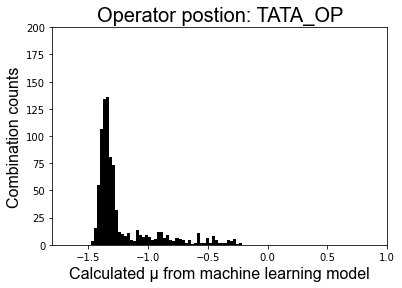

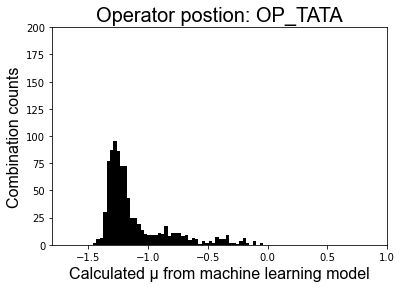

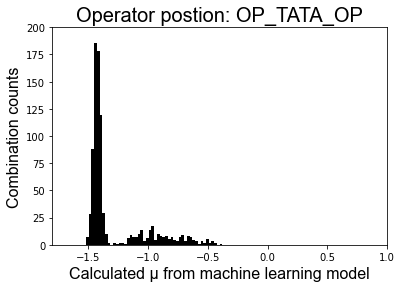

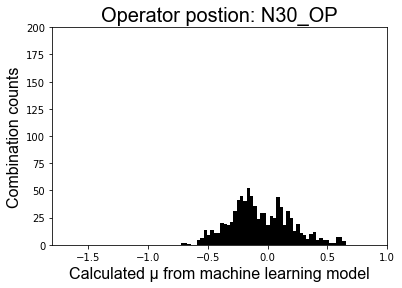

In [119]:
OPs = ['TATA_OP','OP_TATA','OP_TATA_OP','N30_OP']
for OP in OPs:
    OP_stat = curve[curve['Core_pro_design'] == OP].copy()
    plt.hist(OP_stat['pre_Lib_0'].values, bins = _bin_count, color='black')
    plt.title('Operator postion: '+OP,fontsize = 20,fontproperties = 'Arial')
    plt.xlabel('Calculated μ from machine learning model',fontsize = 16,fontproperties = 'Arial')
    plt.ylabel('Combination counts',fontsize = 16,fontproperties = 'Arial')
    plt.axis([-1.8, 1.0, 0, 200])
    plt.savefig('ExportResults/XGB_predict_hist_operator_%s_0511.png'%(OP), dpi = 1000)
    plt.show()

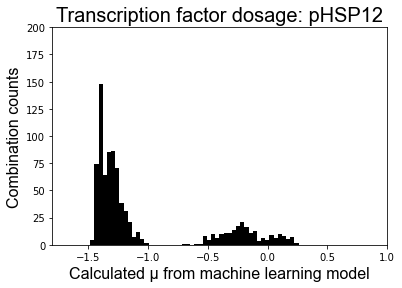

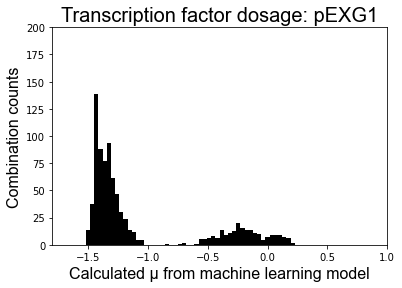

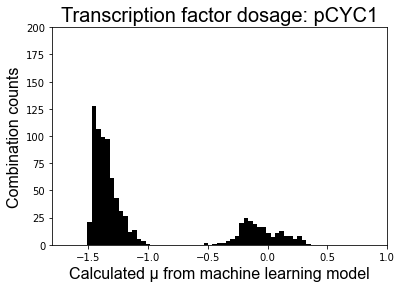

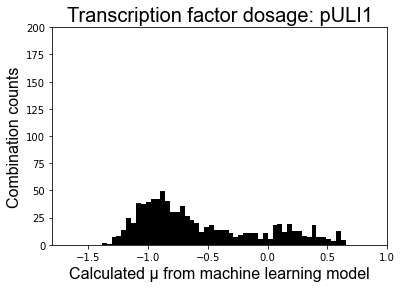

In [120]:
Pros = ['pHSP12','pEXG1','pCYC1','pULI1']
for Pro in Pros:
    Pro_stat = curve[curve['TR_Pro'] == Pro].copy()
    plt.hist(Pro_stat['pre_Lib_0'].values, bins = _bin_count, color='black')
    plt.title('Transcription factor dosage: '+Pro,fontsize = 20,fontproperties = 'Arial')
    plt.xlabel('Calculated μ from machine learning model',fontsize = 16,fontproperties = 'Arial')
    plt.ylabel('Combination counts',fontsize = 16,fontproperties = 'Arial')
    plt.axis([-1.8, 1.0, 0, 200])
    plt.savefig('ExportResults/XGB_predict_hist_TF_dosage_%s_0511.png'%(Pro), dpi = 1000)
    plt.show()

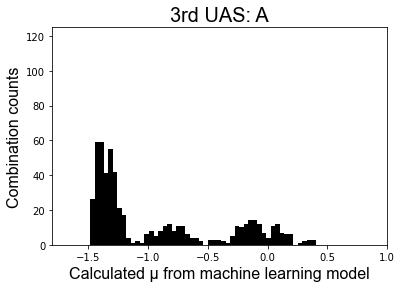

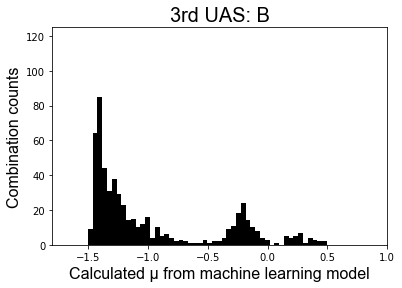

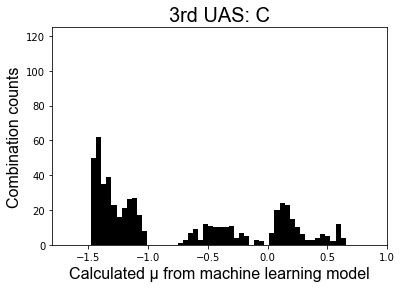

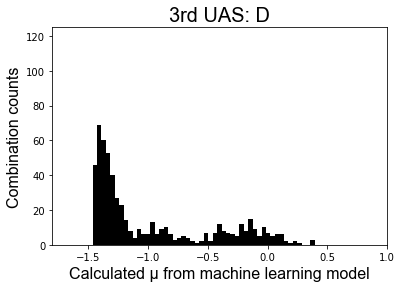

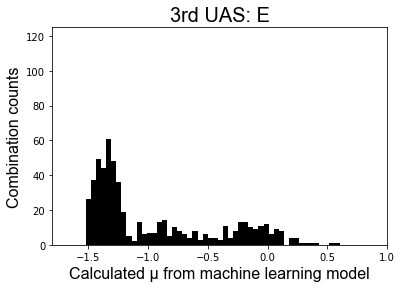

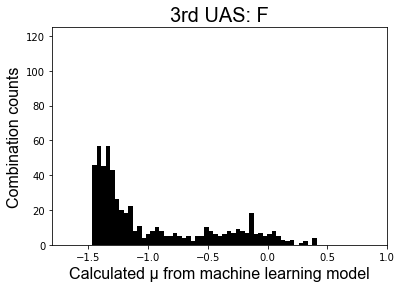

In [121]:
UAS3= ['A','B','C','D','E','F']
for UAS in UAS3:
    UAS3_stat = curve[curve['3rd_UAS'] == UAS].copy()
    plt.hist(UAS3_stat['pre_Lib_0'].values, bins = _bin_count, color='black')
    plt.title('3rd UAS: '+UAS,fontsize = 20,fontproperties = 'Arial')
    plt.xlabel('Calculated μ from machine learning model',fontsize = 16,fontproperties = 'Arial')
    plt.ylabel('Combination counts',fontsize = 16,fontproperties = 'Arial')
    plt.axis([-1.8, 1.0, 0, 125])
    plt.savefig('ExportResults/XGB_predict_hist_3rd_UAS_%s_0511.png'%(UAS), dpi = 1000)
    plt.show()

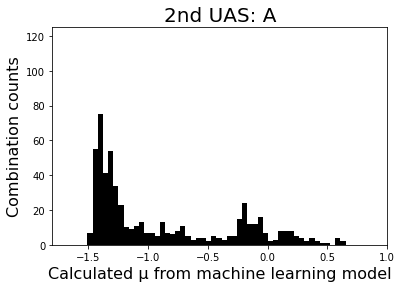

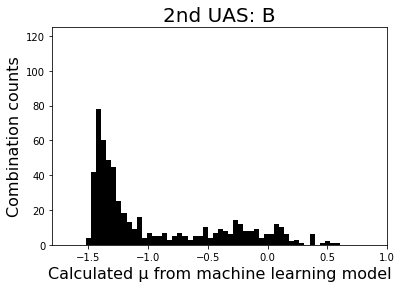

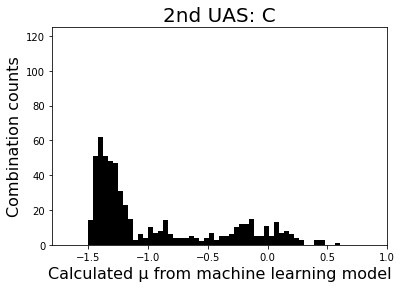

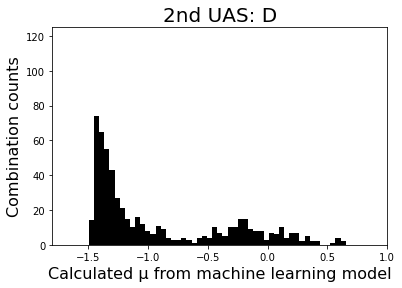

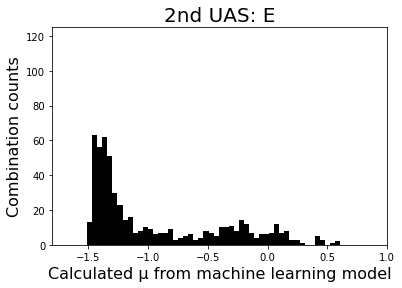

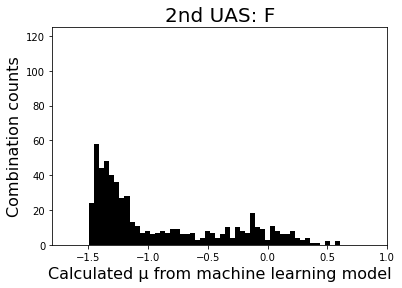

In [94]:
UAS2= ['A','B','C','D','E','F']
for UAS in UAS2:
    UAS2_stat = curve[curve['2nd_UAS'] == UAS].copy()
    plt.hist(UAS2_stat['pre_Lib_0'].values, bins = _bin_count, color='black')
    plt.title('2nd UAS: '+UAS,fontsize = 20)
    plt.xlabel('Calculated μ from machine learning model',fontsize = 16)
    plt.ylabel('Combination counts',fontsize = 16)
    plt.axis([-1.8, 1.0, 0, 125])
    plt.savefig('ExportResults/XGB_predict_hist_2nd_UAS_%s_0511.png'%(UAS), dpi = 1000)
    plt.show()

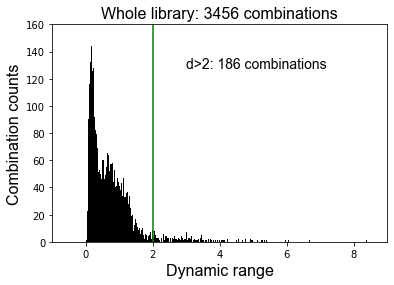

In [132]:
plt.hist(np.float64(curve['Dynamic Range'].values), bins = 350, range=(0,9), color='black')
plt.title('Whole library: '+str(len(curve))+' combinations',fontsize = 16,fontproperties = 'Arial')
plt.xlabel('Dynamic range',fontsize = 16,fontproperties = 'Arial')
plt.ylabel('Combination counts',fontsize = 16,fontproperties = 'Arial')
plt.text(3,128,'d>2: '+str(len(curve[(curve['Dynamic Range']>2)]))+' combinations', fontsize = 14,fontproperties = 'Arial')
plt.axvline(x=2,ls="-",c="green")
plt.axis([-1, 9, 0, 160])
plt.savefig('ExportResults/Dynamic_range_hist_0511.png',bbox_inches='tight',dpi=300,pad_inches=0.1)
plt.show()

In [96]:
curve[(curve['Dynamic Range']>2)].shape

(186, 92)

In [97]:
threshold = 250
curve_FACS = curve[(curve['reads_sum_0A']>threshold) & (curve['reads_sum_0B']>threshold) & \
                   (curve['reads_sum_1A']>threshold) & (curve['reads_sum_1B']>threshold) & \
                   (curve['reads_sum_2A']>threshold) & (curve['reads_sum_2B']>threshold) & \
                   (curve['reads_sum_3A']>threshold) & (curve['reads_sum_3B']>threshold) & \
                   (curve['reads_sum_5A']>threshold) & (curve['reads_sum_5B']>threshold) & \
                   (curve['reads_sum_8A']>threshold) & (curve['reads_sum_8B']>threshold) ].copy()
curve_ML = curve[(curve['reads_sum_0A']<=threshold) | (curve['reads_sum_0B']<=threshold) | \
                   (curve['reads_sum_1A']<=threshold) | (curve['reads_sum_1B']<=threshold) | \
                   (curve['reads_sum_2A']<=threshold) | (curve['reads_sum_2B']<=threshold) | \
                   (curve['reads_sum_3A']<=threshold) | (curve['reads_sum_3B']<=threshold) | \
                   (curve['reads_sum_5A']<=threshold) | (curve['reads_sum_5B']<=threshold) | \
                   (curve['reads_sum_8A']<=threshold) | (curve['reads_sum_8B']<=threshold) ].copy()

In [98]:
curve_FACS.shape

(2333, 92)

In [99]:
curve_FACS[(curve_FACS['Dynamic Range']>2)].shape

(171, 92)

In [100]:
curve_ML.shape

(1123, 92)

In [101]:
curve.shape

(3456, 92)

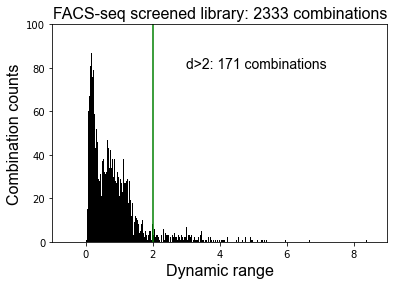

In [131]:
plt.hist(np.float64(curve_FACS['Dynamic Range'].values), bins = 350, range=(0,9), color='black')
plt.title('FACS-seq screened library: '+str(len(curve_FACS))+' combinations',fontsize = 16,fontproperties = 'Arial')
plt.xlabel('Dynamic range',fontsize = 16,fontproperties = 'Arial')
plt.ylabel('Combination counts',fontsize = 16,fontproperties = 'Arial')
plt.text(3,80,'d>2: '+str(len(curve_FACS[(curve_FACS['Dynamic Range']>2)]))+' combinations', fontsize = 14,fontproperties = 'Arial')
plt.axvline(x=2,ls="-",c="green")
plt.axis([-1, 9, 0, 100])
plt.savefig('ExportResults/Dynamic_range_hist_0520_FACS.png',bbox_inches='tight',dpi=300,pad_inches=0.1)
plt.show()

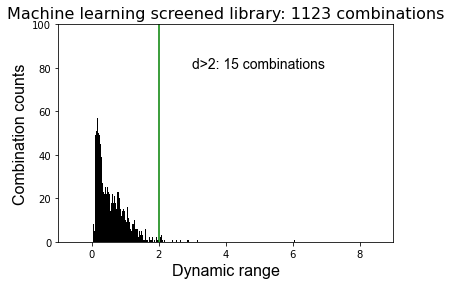

In [130]:
plt.hist(np.float64(curve_ML['Dynamic Range'].values), bins = 350, range=(0,9), color='black')
plt.title('Machine learning screened library: '+str(len(curve_ML))+' combinations',fontsize = 16)
plt.xlabel('Dynamic range',fontsize = 16,fontproperties = 'Arial')
plt.ylabel('Combination counts',fontsize = 16,fontproperties = 'Arial')
plt.text(3,80,'d>2: '+str(len(curve_ML[(curve_ML['Dynamic Range']>2)]))+' combinations', fontsize = 14,fontproperties = 'Arial')
plt.axis([-1, 9, 0, 100])
plt.axvline(x=2,ls="-",c="green")
plt.savefig('ExportResults/Dynamic_range_hist_0520_ML.png',bbox_inches='tight',dpi=300,pad_inches=0.1)
plt.show()

In [104]:
import sys
sys.version

'3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]'

In [105]:
import sklearn

In [106]:
sklearn.__version__

'0.23.2'

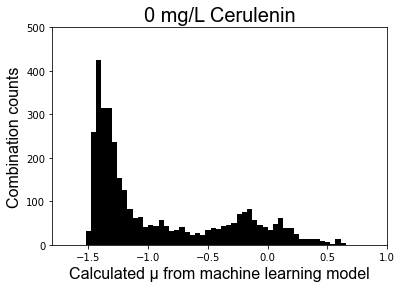

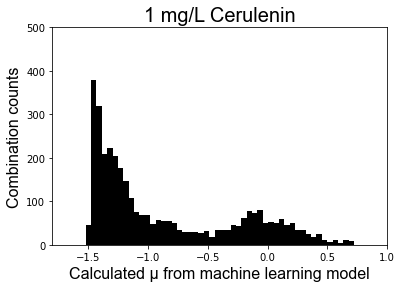

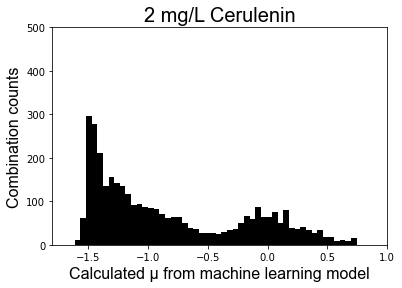

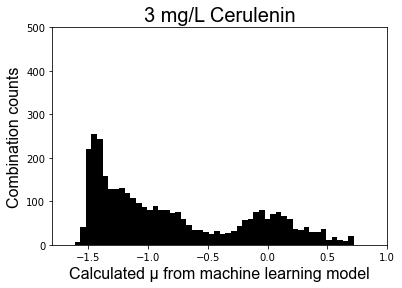

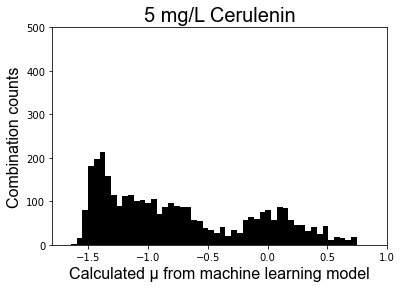

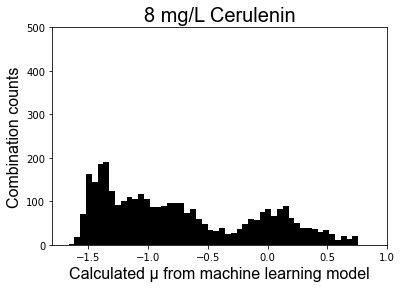

In [126]:
_bin_count = 50
for ce in cerulenin:
    plt.hist(curve['pre_Lib_'+str(ce)].values, bins = _bin_count,color=colors['Lib_'+str(ce)])
    plt.title(str(ce)+' mg/L Cerulenin',fontsize = 20,fontproperties = 'Arial')
    plt.xlabel('Calculated μ from machine learning model',fontsize = 16,fontproperties = 'Arial')
    plt.ylabel('Combination counts',fontsize = 16,fontproperties = 'Arial')
    plt.axis([-1.8, 1.0, 0, 500])
    plt.savefig('ExportResults/predict_hist_Lib%s_%s_0508.png'%(ce,threshold), dpi = 1000)
    plt.show()

In [108]:
from scipy.optimize import curve_fit
combi = results.index[1910]
print(combi)
cerulenin = [0,1,2,3,5,8]
y = 100*10**(results[['pre_Lib_0','pre_Lib_1','pre_Lib_2','pre_Lib_3','pre_Lib_5','pre_Lib_8']].iloc[1910].values)
a, b = curve_fit(hill_func, cerulenin, y,bounds=([0,0,0,1],[(y.max()-y.min()),y.min(),10,3]))

pCYC1-TATA_OP-UAS_FAC


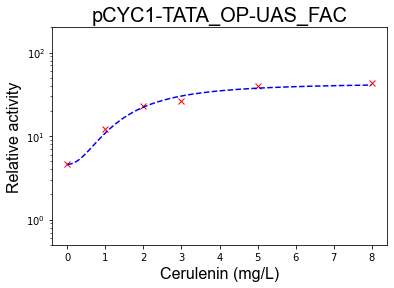

In [127]:
p_cerulenin = [i/100.0 for i in range(0,800,1)]
plt.plot(cerulenin, y, 'rx',label = 'miu')
plt.plot(p_cerulenin, hill_func(p_cerulenin, *a), 'b--',label = 'Fitting curve')
plt.title(combi,fontsize = 20,fontproperties = 'Arial')
plt.xlabel('Cerulenin (mg/L)',fontsize = 16,fontproperties = 'Arial')
plt.ylabel('Relative activity',fontsize = 16,fontproperties = 'Arial')
plt.ylim([0,60])
plt.ylim([0.5,200])
plt.semilogy()
#plt.legend()
plt.savefig('ExportResults/%s_curve_fitting.png'%(combi),dpi = 1000)

In [111]:
Dynamic_sort_.to_excel('Machine_learning/Dynamic_sort.xlsx')

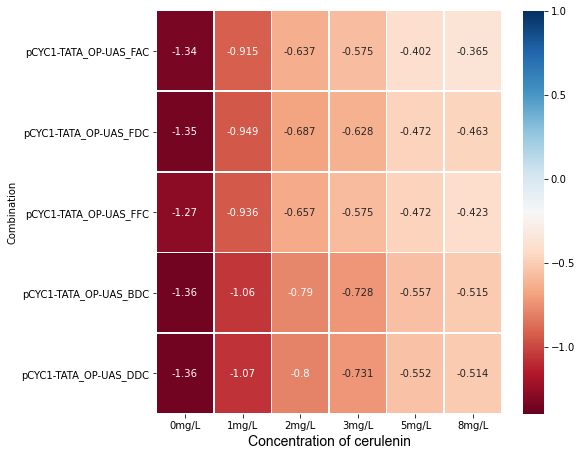

In [128]:
matri_5 = Dynamic_sort_[['pre_Lib_0','pre_Lib_1','pre_Lib_2','pre_Lib_3','pre_Lib_5','pre_Lib_8']][0:5]
fig, ax = plt.subplots(figsize=(12,8)) 
ax = sns.heatmap(matri_5, vmin=-1.4, vmax= 1.0,cmap='RdBu',\
                 robust=False, annot = True, \
                 fmt='.3g', linewidths=0.5, \
                 linecolor='white', cbar=True, square=False, \
                 xticklabels=['0mg/L','1mg/L','2mg/L','3mg/L','5mg/L','8mg/L'], ax=ax)
plt.xlabel('Concentration of cerulenin',fontsize = 14,fontproperties = 'Arial')
plt.subplots_adjust(left = 0.4, bottom = 0.2, right = 0.9, top = 0.9)
plt.savefig('ExportResults/LargeDynamic_Top5.png',bbox_inches='tight',dpi=300,pad_inches=0.1) 
plt.show()